In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install numpy pandas scikit-learn tensorflow keras gensim nltk transformers

In [3]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, SpatialDropout1D, BatchNormalization
from gensim.models import Word2Vec, FastText
import tensorflow as tf
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
# Load dataset
olid = pd.read_csv("/content/drive/MyDrive/PG_Project_JU /Datasets/OLID.csv")

In [5]:
olid.head(10)

,Text,Label
0,@USER She should ask a few native Americans wh...,1
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1
2,Amazon is investigating Chinese employees who ...,0
3,"@USER Someone should'veTaken"" this piece of sh...",1
4,@USER @USER Obama wanted liberals &amp; illega...,0
5,@USER Liberals are all Kookoo !!!,1
6,@USER @USER Oh noes! Tough shit.,1
7,@USER was literally just talking about this lo...,1
8,@USER Buy more icecream!!!,0
9,@USER Canada doesn’t need another CUCK! We alr...,1


In [6]:
olid.shape

(13240, 2)

In [7]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, numbers, and URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


In [8]:
olid['cleaned_text'] = olid['Text'].apply(preprocess_text)

In [9]:
import pandas as pd
import numpy as np

# Load NRC Emotion Lexicon
nrc_lexicon = pd.read_csv("/content/drive/MyDrive/PG_Project_JU /Datasets/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", sep='\t', header=None, names=['word', 'emotion', 'association'])
relevant_emotions = ["anticipation", "joy", "surprise", "trust", "sadness", "anger", "disgust", "fear"]
nrc_lexicon = nrc_lexicon[nrc_lexicon['emotion'].isin(relevant_emotions)]
emotion_dict = nrc_lexicon[nrc_lexicon['association'] == 1].groupby('word')['emotion'].apply(list).to_dict()

# Function to compute emotion scores
def get_emotion_features(text):
    words = text.split()
    emotion_scores = {emotion: 0 for emotion in relevant_emotions}
    for word in words:
        if word in emotion_dict:
            for emotion in emotion_dict[word]:
                emotion_scores[emotion] += 1
    return np.array(list(emotion_scores.values()))

# Extract emotion features
emotion_features = np.array([get_emotion_features(text) for text in olid['cleaned_text']])

In [10]:
print(emotion_features)

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
emotion_features.shape


(13240, 8)

In [12]:
# Train FastText model
fasttext_model = FastText(sentences=olid['cleaned_text'].apply(lambda x: x.split()), vector_size=100, window=5, min_count=1)

# Function to generate embeddings for sentences
def get_sentence_embedding(sentence):
    words = sentence.split()
    embeddings = [fasttext_model.wv[word] for word in words if word in fasttext_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(100)  # Return a zero vector if no words are in the vocabulary

# Apply FastText to the cleaned text
olid['fasttext_embeddings'] = olid['cleaned_text'].apply(get_sentence_embedding)

In [13]:
print(olid['fasttext_embeddings'])

0        [-0.12913354, -0.015419805, -0.8785966, 0.9881...
1        [-0.12568477, -0.20305996, -0.84853303, 1.3956...
2        [-0.101802304, 0.18407091, -0.7423482, 0.43692...
3        [-0.08896038, -0.08223448, -0.6426811, 0.89116...
4        [-0.16268916, 0.04557252, -1.1133024, 1.102736...
                               ...                        
13235    [-0.12283464, 0.10810582, -0.84851336, 0.68632...
13236    [-0.08635618, 0.11873083, -0.58756745, 0.41087...
13237    [-0.124942325, -0.036247935, -0.8267076, 0.952...
13238    [-0.071650095, -0.5769503, -0.37162033, 1.6229...
13239    [-0.08030813, -0.68544436, -0.42346442, 1.9182...
Name: fasttext_embeddings, Length: 13240, dtype: object


In [14]:
olid['fasttext_embeddings'].shape

(13240,)

In [15]:
from gensim.models import Word2Vec
import numpy as np

# Train Word2Vec Model
word2vec_model = Word2Vec(sentences=olid['cleaned_text'].apply(lambda x: x.split()), vector_size=100, window=5, min_count=1, workers=4)

# Function to generate Word2Vec embeddings
def get_word2vec_embedding(sentence):
    words = sentence.split()
    embeddings = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(100)

# Apply Word2Vec embeddings
olid['word2vec_embeddings'] = olid['cleaned_text'].apply(get_word2vec_embedding)


In [16]:
print(olid['word2vec_embeddings'])

0        [-0.694861, 0.44747704, -0.14644475, 0.0772018...
1        [-0.924482, 0.7242302, -0.08780121, 0.23933342...
2        [-0.25679228, 0.21462752, -0.015459313, -0.018...
3        [-0.54570407, 0.37956902, -0.094192356, 0.1325...
4        [-0.7155453, 0.47493267, -0.1520735, 0.0819917...
                               ...                        
13235    [-0.45372817, 0.29781875, -0.103077084, 0.0306...
13236    [-0.23317547, 0.24351306, 0.020821262, 0.03424...
13237    [-0.6297853, 0.41176865, -0.1313044, 0.1474659...
13238    [-0.77535355, 0.52560586, -0.103302106, 0.3458...
13239    [-0.8700733, 0.5943665, -0.11124444, 0.4167435...
Name: word2vec_embeddings, Length: 13240, dtype: object


In [17]:
olid['word2vec_embeddings'].shape

(13240,)

In [18]:
# Load Pretrained GloVe Embeddings
def load_glove_embeddings(glove_path):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

glove_path = "/content/drive/MyDrive/PG_Project_JU /Datasets/glove.6B.100d.txt"  # Change if using a different version
glove_embeddings = load_glove_embeddings(glove_path)

# Function to generate GloVe sentence embeddings
def get_glove_embedding(sentence):
    words = sentence.split()
    embeddings = [glove_embeddings[word] for word in words if word in glove_embeddings]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(100)

# Apply GloVe embeddings
olid['glove_embeddings'] = olid['cleaned_text'].apply(get_glove_embedding)


In [19]:
print(olid['glove_embeddings'])

0        [-0.1115192, 0.314648, 0.531674, -0.0601902, 0...
1        [-0.24394472, -0.005023503, 0.299069, -0.21946...
2        [-0.025366379, 0.04800339, 0.3071562, 0.098977...
3        [-0.30400398, 0.3162896, 0.4043924, -0.2063114...
4        [-0.18432525, 0.17296939, 0.32290548, -0.41639...
                               ...                        
13235    [0.06706186, 0.27106953, 0.39556372, -0.421223...
13236    [0.039258003, 0.0743708, -0.149896, 0.00810799...
13237    [-0.32460436, 0.20181966, 0.49915662, -0.58270...
13238    [-0.14034, -0.050146, 0.39918, -0.4014585, 0.0...
13239    [-0.45582008, 0.057273902, 0.46033, 0.01519118...
Name: glove_embeddings, Length: 13240, dtype: object


In [20]:
olid['glove_embeddings'].shape

(13240,)

In [77]:
import numpy as np

# Ensure emotion_features is a NumPy array
emotion_features = np.array([get_emotion_features(text) for text in olid['cleaned_text']])

# Convert FastText embeddings into a NumPy array
fasttext_embeddings = np.vstack(olid['fasttext_embeddings'].values)
word2vec_embeddings = np.vstack(olid['word2vec_embeddings'].values)
glove_embeddings = np.vstack(olid['glove_embeddings'].values)


# Concatenate FastText embeddings with emotion features
final_features = np.hstack((word2vec_embeddings, glove_embeddings))

# Convert back to DataFrame if needed
final_feature_df = pd.DataFrame(final_features)


In [90]:
from sklearn.model_selection import train_test_split

# Assuming 'cyber_troll' contains the target labels in a column named 'label'
X = np.vstack(olid['fasttext_embeddings'].values)
#X = np.vstack(final_feature_df.values)
#X = emotion_features
y = olid['Label'].values  # Labels

# 80:20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [91]:
# Reshape for LSTM/CNN (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Check shape
print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Train Shape: (10592, 1, 100), Test Shape: (2648, 1, 100)


In [92]:
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])


lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6566 - loss: 0.6444 - val_accuracy: 0.6640 - val_loss: 0.6307
Epoch 2/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6716 - loss: 0.6294 - val_accuracy: 0.6640 - val_loss: 0.6318
Epoch 3/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6615 - loss: 0.6363 - val_accuracy: 0.6640 - val_loss: 0.6316
Epoch 4/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6660 - loss: 0.6330 - val_accuracy: 0.6640 - val_loss: 0.6311
Epoch 5/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6606 - loss: 0.6360 - val_accuracy: 0.6640 - val_loss: 0.6316
Epoch 6/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6660 - loss: 0.6334 - val_accuracy: 0.6640 - val_loss: 0.6349
Epoch 7/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6724 - loss: 0.6290 - val_accuracy: 0.6640 - val_loss: 0.6328
Epoch 8/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6611 - loss: 0.6361 - val_accuracy: 0.6640 - val

In [93]:
# Predict on test set
y_pred_lstm = lstm_model.predict(X_test)

# Convert probabilities to binary class labels (0 or 1)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)

# Print classification report
print("LSTM Model Performance:\n", classification_report(y_test, y_pred_lstm))

# Print accuracy
print("Test Accuracy:", accuracy_score(y_test, y_pred_lstm))

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
LSTM Model Performance:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80      1768
           1       0.00      0.00      0.00       880

    accuracy                           0.67      2648
   macro avg       0.33      0.50      0.40      2648
weighted avg       0.45      0.67      0.53      2648

Test Accuracy: 0.6676737160120846


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [82]:
cnn_model = Sequential([
    Conv1D(64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])), # Changed kernel_size to 1
    MaxPooling1D(pool_size=1), # Changed pool_size to 1 as input size is 1 after convolution
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6739 - loss: 0.6080 - val_accuracy: 0.7140 - val_loss: 0.5684
Epoch 2/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7252 - loss: 0.5434 - val_accuracy: 0.7353 - val_loss: 0.5258
Epoch 3/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7398 - loss: 0.5282 - val_accuracy: 0.7390 - val_loss: 0.5244
Epoch 4/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7429 - loss: 0.5243 - val_accuracy: 0.7286 - val_loss: 0.5319
Epoch 5/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7542 - loss: 0.5069 - val_accuracy: 0.7353 - val_loss: 0.5226
Epoch 6/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7482 - loss: 0.5178 - val_accuracy: 0.7367 - val_loss: 0.5243
Epoch 7/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7550 - loss: 0.5062 - val_accuracy: 0.7404 - val_loss: 0.5185
Epoch 8/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7475 - loss: 0.5082 - val_accuracy: 0.7428 - val_

In [83]:
# Predict on test set
y_pred_cnn = cnn_model.predict(X_test)

# Convert probabilities to binary class labels (0 or 1)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)

# Print classification report
print("CNN Model Performance:\n", classification_report(y_test, y_pred_cnn))

# Print accuracy
print("Test Accuracy:", accuracy_score(y_test, y_pred_cnn))

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
CNN Model Performance:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83      1768
           1       0.68      0.48      0.56       880

    accuracy                           0.75      2648
   macro avg       0.73      0.68      0.70      2648
weighted avg       0.74      0.75      0.74      2648

Test Accuracy: 0.7530211480362538


In [84]:
bilstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


265/265 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6767 - loss: 0.6113 - val_accuracy: 0.7192 - val_loss: 0.5357
Epoch 2/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7396 - loss: 0.5275 - val_accuracy: 0.7220 - val_loss: 0.5304
Epoch 3/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7350 - loss: 0.5337 - val_accuracy: 0.7334 - val_loss: 0.5250
Epoch 4/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7365 - loss: 0.5285 - val_accuracy: 0.7282 - val_loss: 0.5213
Epoch 5/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7452 - loss: 0.5221 - val_accuracy: 0.7206 - val_loss: 0.5275
Epoch 6/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7483 - loss: 0.5082 - val_accuracy: 0.7230 - val_loss: 0.5422
Epoch 7/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7373 - loss: 0.5205 - val_accuracy: 0.7319 - val_loss: 0.5243
Epoch 8/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7512 - loss: 0.5065 - val_accuracy: 0.72

In [85]:
# Predict on test set
y_pred_bilstm = bilstm_model.predict(X_test)

# Convert probabilities to binary class labels (0 or 1)
y_pred_bilstm = (y_pred_bilstm > 0.5).astype(int)

# Print classification report
print("Bi-LSTM Model Performance:\n", classification_report(y_test, y_pred_bilstm))

# Print accuracy
print("Test Accuracy:", accuracy_score(y_test, y_pred_bilstm))

83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Bi-LSTM Model Performance:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82      1768
           1       0.65      0.50      0.57       880

    accuracy                           0.74      2648
   macro avg       0.71      0.68      0.69      2648
weighted avg       0.73      0.74      0.73      2648

Test Accuracy: 0.7435800604229608


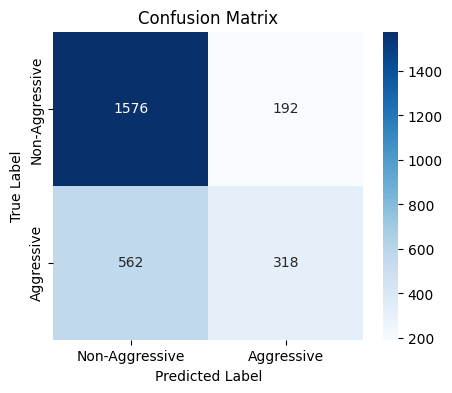

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_lstm)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Aggressive', 'Aggressive'], yticklabels=['Non-Aggressive', 'Aggressive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()